## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from sklearn.pipeline import Pipeline, make_pipeline

## Обзор данных

#### Чтение датасета

In [2]:
df = pd.read_csv("moldova_cars_dataset.csv")

In [3]:
df.head(2)

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011.0,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014.0,Universal,135000.0,1500.0,Diesel,Manual,8550.0


Датасет содержит следующие столбцы:

- `Make` - марка машины
- `Model` - модель машины
- `Year` - год выпуска
- `Style` - тип машины
- `Distance` - пробег
- `Engine_capacity(cm3)` - объём двигателя
- `Fuel_type` - вид топлива
- `Transmission` - тип трансмиссии
- `Price(euro)` - цена в евро

#### Получение информации о данных в столбцах датафрейма

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41007 entries, 0 to 41006
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  41007 non-null  object 
 1   Model                 40671 non-null  object 
 2   Year                  40771 non-null  float64
 3   Style                 40938 non-null  object 
 4   Distance              40889 non-null  float64
 5   Engine_capacity(cm3)  41007 non-null  float64
 6   Fuel_type             41007 non-null  object 
 7   Transmission          40779 non-null  object 
 8   Price(euro)           41007 non-null  float64
dtypes: float64(4), object(5)
memory usage: 2.8+ MB


#### Выводы

- Заголовки нужно привести к lower case и заменить разделяющие пробелы на знаки нижнего подчёркивания
- Требуется обработка пропущенных значений
- Требуется обработка дубликатов
- Столбцы `Make`, `Model`, `Style`, `Fuel_type`, `Transmission` требуется привести к числовому типу

## Предварительная обработка данных

#### Форматирование заголовков датафрейма

In [5]:
df.columns = [column.strip().lower() for column in df.columns]

df = df.rename(columns={ "engine_capacity(cm3)": "engine_capacity", "price(euro)": "price" })

In [6]:
df.columns

Index(['make', 'model', 'year', 'style', 'distance', 'engine_capacity',
       'fuel_type', 'transmission', 'price'],
      dtype='object')

#### Обработка пропущенных значений

Так как линейная регрессия (да и вообще любая модель) сильно зависит от данных на входе, то заполнять пропуски случайными значениями считаю нецелесообразным, а поэтому удаляю все данные с пропущенными значениями.

In [7]:
df = df.dropna()

#### Обработка дубликатов

По тем же причинам удаляю все строки-дубликаты.

In [8]:
df = df.drop_duplicates()

#### Приведение категориальных признаков к числовому типу

In [9]:
label_encoder = LabelEncoder()

In [10]:
df["make"] = label_encoder.fit_transform(df["make"])

In [11]:
df["model"] = label_encoder.fit_transform(df["model"])

In [12]:
df["style"] = label_encoder.fit_transform(df["style"])

In [13]:
df["fuel_type"] = label_encoder.fit_transform(df["fuel_type"])

In [14]:
df["transmission"] = label_encoder.fit_transform(df["transmission"])

In [15]:
df.head(2)

,make,model,year,style,distance,engine_capacity,fuel_type,transmission,price
0,79,570,2011.0,4,195000.0,1800.0,2,0,7750.0
1,66,383,2014.0,11,135000.0,1500.0,0,1,8550.0


Не супер крутое решение, конечно, ибо теперь получается, что УАЗ может быть "в 6 раз лучше" Toyota (имеется в виду трактовка признаков). Но One-Hot Encoding на столбце моделей даёт больше восьмиста (!) столбцов сверху...

## EDA

#### Описательная статистика датафрейма

In [16]:
df.describe()

,make,model,year,style,distance,engine_capacity,fuel_type,transmission,price
count,36441.000000,36441.000000,36441.000000,36441.000000,3.644100e+04,36441.000000,36441.000000,36441.000000,3.644100e+04
mean,51.846299,397.042672,2007.723059,7.573365,4.759444e+05,1859.135123,1.923603,0.555336,9.589220e+03
std,25.385137,233.085322,8.287601,3.201571,4.582778e+06,707.513603,1.867344,0.496935,5.340259e+04
min,0.000000,0.000000,1900.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,28.000000,178.000000,2004.000000,4.000000,9.000000e+04,1499.000000,0.000000,0.000000,3.333000e+03
50%,58.000000,383.000000,2009.000000,9.000000,1.700000e+05,1800.000000,2.000000,1.000000,6.499000e+03
75%,72.000000,593.000000,2014.000000,10.000000,2.300000e+05,2000.000000,4.000000,1.000000,1.180000e+04
max,86.000000,823.000000,2021.000000,11.000000,1.000000e+08,9999.000000,5.000000,1.000000,1.000000e+07


#### Тепловая карта корреляций

<Axes: >

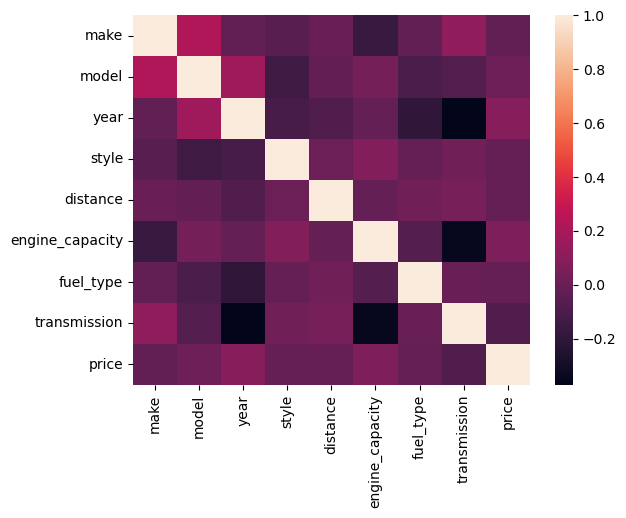

In [17]:
sns.heatmap(df.corr())

#### Анализ доли каждой из марок машин на рынке Молдавии

Знал бы, что надо будет гистограмму строить, не преобразовывал бы категориальные признаки так рано :(

In [18]:
unique_makes = df["make"].unique()

In [19]:
counts = df["make"].value_counts() / len(df)

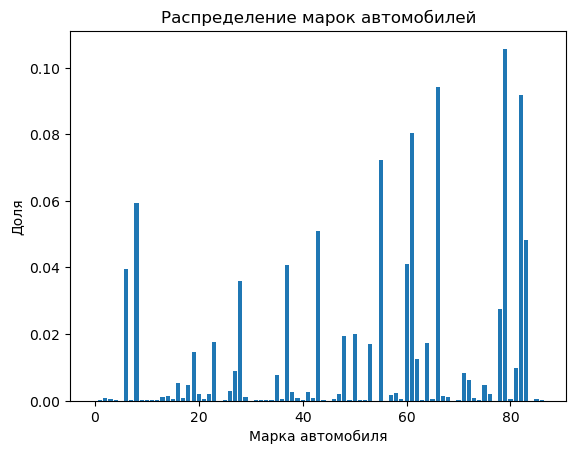

In [20]:
plt.title('Распределение марок автомобилей')
plt.bar(unique_makes, counts)
plt.xlabel("Марка автомобиля")
plt.ylabel("Доля")
plt.show()

По графику можно сделать вывод, что граждане Молдавии в своём большинстве пользуются лишь десятью популярными марками автомобилей. Остальные 70 марок занимают нишевые места любителей.

## Обучение моделей линейной регрессии

#### Разделение данных на матрицу признаков и предсказываемые значения

In [21]:
y = df.loc[:, "price"]
X = df.drop("price", axis=1)

#### Разбиение данных на обучающую и тестовую выборки

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

#### Масштабирование признаков

Это особенно важно, когда признаки имеют сильно различающиеся диапазоны значений, поскольку алгоритмы могут быть чувствительны к масштабам признаков. Например, если один признак имеет значения в диапазоне от 0 до 1, а другой — от 0 до 1000, без масштабирования алгоритм может придавать большее значение второму признаку просто из-за его больших значений, даже если первый признак более важен для предсказания целевой переменной. Масштабируя признаки, мы делаем их сопоставимыми, что позволяет алгоритмам лучше находить зависимости между признаками и целевой переменной.

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Обучение базовой модели линейной регрессии

In [24]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

y_pred = linear_regression.predict(X_test)

#### Анализ качества обучения базовой модели линейной регрессии

In [25]:
print(f"[+] MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"[+] MSE: {mean_squared_error(y_test, y_pred)}")
print(f"[+] RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"[+] MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")
print(f"[+] R^2-score: {linear_regression.score(X_test, y_test)}")

[+] MAE: 4591.727576564386
[+] MSE: 92541559.11687487
[+] RMSE: 9619.852343818739
[+] MAPE: 1.0270034784109412
[+] R^2-score: 0.3135941544152929


Честно говоря, как-то грустненько моделька обучилась. Совсем грустненько. Попробую это исправить.

#### Обучение с регуляризацией и подбором параметра регуляризации

In [26]:
parameters = { "alpha": np.arange(0, 10000, 100) }

In [27]:
grids = GridSearchCV(Ridge(), parameters).fit(X_train, y_train)

In [28]:
bestpar = grids.best_params_
bestpar

{'alpha': 1400}

In [29]:
ridge = Ridge(alpha=bestpar["alpha"]).fit(X_train, y_train)

y_pred = ridge.predict(X_test)

print(f"[+] MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"[+] MSE: {mean_squared_error(y_test, y_pred)}")
print(f"[+] RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"[+] MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")
print(f"[+] R^2-score: {ridge.score(X_test, y_test)}")

[+] MAE: 4571.31691181438
[+] MSE: 92475131.20604691
[+] RMSE: 9616.399076891876
[+] MAPE: 1.0094071211255418
[+] R^2-score: 0.3140868682482716


In [30]:
parameters = { "alpha": np.arange(100, 500, 10) }

In [31]:
grids = GridSearchCV(Lasso(), parameters).fit(X_train, y_train)

In [32]:
bestpar = grids.best_params_
bestpar

{'alpha': 250}

In [33]:
lasso = Lasso(alpha=bestpar["alpha"]).fit(X_train, y_train)

y_pred = lasso.predict(X_test)

print(f"[+] MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"[+] MSE: {mean_squared_error(y_test, y_pred)}")
print(f"[+] RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"[+] MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")
print(f"[+] R^2-score: {lasso.score(X_test, y_test)}")

[+] MAE: 4557.0432727841835
[+] MSE: 92530510.01088095
[+] RMSE: 9619.278040002844
[+] MAPE: 0.986959440780624
[+] R^2-score: 0.313676108631486


#### Сборка обучения в конвейер

In [34]:
pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(2), Ridge())
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(f"[+] MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"[+] MSE: {mean_squared_error(y_test, y_pred)}")
print(f"[+] RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"[+] MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")

[+] MAE: 3946.213964358055
[+] MSE: 75835130.6719358
[+] RMSE: 8708.336848786672
[+] MAPE: 0.8620097784401246


## Заключение

Лучше всего себя показала обученная модель без регуляризаций. Скорее всего, это связано с тем, что регуляризации ограничивают и так не лучшую по качеству модель. Плохое же качество, вероятно, связано с переводом категориальных признаков в числовые.